In [136]:
import numpy as np
import pandas as pd
import sidetable as stb
import glob, os
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
import dataframe_image as dfi
import win32com.client as win32

Sample of initial inventory report.

In [138]:
sample = pd.read_fwf(r'C:\Retailer\Filename.txt',header=None)

In [139]:
print(sample.head())

0  01468000000000146000000000100000203011202000000038151000000010
1  04468000000000146000000000110000203011202000000000001000000011
2  03468000000000146000000000120000203011202000000003601000000012
3  01468000000000146000000000130000203011202000000097401000000013
4  04468000000000146000000000140000203011202000000019401000000014


Path to the folder with all inventory reports in txt format. They will be collected, stacked and used for further analytics.

In [100]:
path = r'C:\Retailer'
all_files = glob.glob(path + "/*.txt")

Variable that shows how txt file should be splitted based on value's position and length.

In [101]:
col_specification = [(0,2),(2,15),(15,28),(28,30),
                     (30,34),(34,36),(36,38),(38,42),(42,52),(52,62)]

In [102]:
li = []

for filename in all_files:
    df = pd.read_fwf(filename, header=None,colspecs=col_specification,float_format='%.f')
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df = df.dropna() # Script drops N/A values. They may appear if file has blank lines.

df.columns = ['Movement_Code','GLN_Code','EAN_Code','Site_Item_Type',
                  'Case_Count','Movement_Day','Movement_Month','Movement_Year',
                    'Quantity','Base_Unit_Code']

Sample of initial date.

Necessary formats are applied to certain columns.

In [103]:
df[['GLN_Code','EAN_Code','Base_Unit_Code','Case_Count']] = \
df[['GLN_Code','EAN_Code','Base_Unit_Code','Case_Count']].astype(str).replace('\.0', '', regex=True)

df['Quantity'] = df['Quantity'].astype(int)

Date in initial format DDMMYYY is splitted into day, month and year and then joined with delimeters between. 
New date format is DD-MM-YYYY.

In [104]:
df['Movement_Day'] = df['Movement_Day'].astype(str).replace('\.0', '', regex=True)
df['Movement_Day'] = df['Movement_Day'].str.zfill(2)
df['Movement_Month'] = df['Movement_Month'].astype(str).replace('\.0', '', regex=True)
df['Movement_Month'] = df['Movement_Month'].str.zfill(2)
df['Movement_Year'] = df['Movement_Year'].apply(str).replace('\.0', '', regex=True)
df['Movement_Date'] = df["Movement_Day"] + "-" + df["Movement_Month"] + "-" + df["Movement_Year"]
df['Movement_Date'] = df['Movement_Date'].apply(str).replace('\.0', '', regex=True)
df['Movement_Date'] = pd.to_datetime(df.Movement_Date,format = '%d-%m-%Y', dayfirst=True)
df = df.drop(['Movement_Day','Movement_Month','Movement_Year'], axis=1) 

If there are no OOS quantities in processed files,then only Stock, Transit and Shipped are renamed.

In [105]:
if 5 in df['Movement_Code']:
    df['Movement_Code'] = df['Movement_Code'].replace([1,4,3,5],
                                                      ['Stock','Transit','Shipped','OOS'])
else: 
    df['Movement_Code'] = df['Movement_Code'].replace([1,4,3],
                                                      ['Stock','Transit','Shipped'])

Site Item Types values are replaced by Standard and Promo.

In [106]:
df['Site_Item_Type'] = df['Site_Item_Type'].replace([0,1],
                                                    ['Standard','Promo'])

Columns' order is changed for dataframe.

In [107]:
df = df[['Movement_Code','GLN_Code','EAN_Code','Site_Item_Type',
                  'Case_Count','Movement_Date','Quantity','Base_Unit_Code']]

Function for top 10 shipped products within last 30 days.

In [108]:
def TopShipped(dataframe):
    dfShipped = dataframe[(dataframe['Movement_Code']=='Shipped') &
               (dataframe['Movement_Date']>(dataframe['Movement_Date'].max() - pd.Timedelta(days=30)))]
    dfShipped = dfShipped.groupby('EAN_Code',as_index=False)['Quantity'].sum()
    dfShipped = dfShipped.sort_values(by=['Quantity'],ascending=False)
    dfShipped['%'] = (dfShipped['Quantity'] / dfShipped['Quantity'].sum()).map("{:.2%}".format)
    dfShipped['Quantity'] = dfShipped['Quantity'].apply(lambda x : "{:,}".format(x))
    dfShipped.reset_index(drop=True,inplace=True)
    dfShipped.style.hide_index()
    print(dfShipped.head(10))

Products with no transit since specific date. This list of SKUs was needed to exclude products that had been overstocked before project's launch date.

In [109]:
def NoTransit(dataframe,cutoff_date):
    dfNoTransit = dataframe[(dataframe['Movement_Code']=='Transit') & (dataframe['Movement_Date']>=cutoff_date)]
    dfNoTransit = dfNoTransit.groupby('EAN_Code',as_index=False)['Quantity'].sum()
    dfNoTransit = dfNoTransit[dfNoTransit['Quantity'] == 0]
    dfNoTransit_list = dfNoTransit['EAN_Code'].to_list()
    print(dfNoTransit_list)                

Initial dataframe is transposed to Pivot table.

In [110]:
dfPivot = pd.pivot_table(df,aggfunc='sum',values='Quantity',
                         index=['Movement_Date','EAN_Code','Base_Unit_Code'],
                         columns='Movement_Code').reset_index()

As data may be inconsistent, I decided to replace N/A values with 0. Mainly it concerns lines with no OOS values.

In [111]:
dfPivot = dfPivot.fillna(0)

Columns' order is changed for pivot dataframe.

In [112]:
Movement_Codes_Order = ['Movement_Week','Movement_Date','EAN_Code','Base_Unit_Code',
                        'Stock','Transit','Shipped','OOS','Demand']

dfPivot = dfPivot.reindex(Movement_Codes_Order,axis=1)

Column that includes the calendar week number of movement.

In [113]:
dfPivot['Movement_Week'] = 'cw'+dfPivot['Movement_Date'].dt.strftime('%V')

Condition for Demand column's calculation.

In [114]:
if 'OOS' in df['Movement_Code'].unique():
    dfPivot['OOS'] = dfPivot['OOS'].fillna(0)
    dfPivot['Demand'] = dfPivot['Shipped'] + dfPivot['OOS']
else:
    dfPivot['OOS'] = dfPivot['OOS'].fillna(0)
    dfPivot['Demand'] = dfPivot['Shipped']

Renamed the axis column that was added to pivot table.

In [115]:
dfPivot = dfPivot.rename_axis("Line_ID",axis=1)

All columns with quantities get Integer format.

In [116]:
dfPivot.iloc[:, 4:] = dfPivot.iloc[:, 4:].astype(int)

Rows are sorted based on movement date.

In [117]:
dfPivot = dfPivot.sort_values(by=['Movement_Date'],ascending=False,inplace=False)

Index column works as Line_ID (OID)

In [118]:
dfPivot.reset_index(drop=True,inplace=True)
dfPivot.sort_index(ascending=False,inplace=True)

Dataframe with Service Level calculated on a weekly basis.

In [119]:
dfSLW = dfPivot.groupby('Movement_Week',as_index=False)[['Shipped','OOS','Demand']].sum()
dfSLW = dfSLW[dfSLW['Movement_Week'] >= 'cw39']
dfSLW['Service_Level_%'] = (dfSLW['Shipped'] / dfSLW['Demand'])
dfSLW['Service_Level_%'] = dfSLW['Service_Level_%'].astype(float).map("{:.2%}".format)
dfSLW['Service_Level_%'] = dfSLW['Service_Level_%'].str.rstrip('%').astype('float')
dfSLW.sort_values(by=['Movement_Week'],ascending=False,inplace=True)
dfSLW.sort_index(ascending=True,inplace=True)
print(dfSLW.head(5))

Line_ID Movement_Week  Shipped    OOS  Demand  Service_Level_%
6                cw39   300584  27863  328447            91.52
7                cw40   175121   7032  182153            96.14
8                cw41   212843   1737  214580            99.19
9                cw42   213921   4730  218651            97.84
10               cw43   220270   2007  222277            99.10


Dataframe with Service Level calculated on a daily basis.

In [120]:
dfSLD = dfPivot.groupby('Movement_Date',as_index=False)[['Shipped','OOS','Demand']].sum()
dfSLD['Service_Level'] = (dfSLD['Shipped'] / dfSLD['Demand'])
dfSLD['Service_Level'] = dfSLD['Service_Level'].astype(float).map("{:.2%}".format)
dfSLD.sort_values(by=['Movement_Date'],ascending=False,inplace=False)
dfSLD.sort_index(ascending=False,inplace=True)

Daily average sales. Meant for KPI report on a daily basis.

In [143]:
daily_moving_averages = dfSLD['Demand'].rolling(7,center=False).mean().shift(-6).map('{:.0f}'.format)
seven_days_moving_average = daily_moving_averages.iloc[0]
seven_days_moving_average = float(seven_days_moving_average)
print('Daily average sales: ',seven_days_moving_average)

Daily average sales:  50440.0


1-week average sales. Meant for KPI report on a weekly basis. The correct value for the latest week can be calculated on Monday.

In [144]:
weekly_moving_averages = dfSLW['Demand'].rolling(1,center=False).mean().map('{:.0f}'.format)
one_week_moving_average = weekly_moving_averages.iloc[0]
one_week_moving_average = float(one_week_moving_average)
print('Weekly average sales: ',one_week_moving_average)

Weekly average sales:  328447.0


Dataframe with Stock Coverage calculated on a weekly basis.

In [123]:
dfTCW = dfPivot.groupby('Movement_Week',as_index=False)[['Stock']].sum()
dfTCW = dfTCW[dfTCW['Movement_Week'] >= 'cw39']
dfTCW['Total_Coverage'] = dfTCW['Stock'].div(one_week_moving_average).map('{:.1f}'.format)
dfTCW['Total_Coverage'] = dfTCW['Total_Coverage'].astype(float)
dfTCW.sort_values(by=['Movement_Week'],ascending=True,inplace=False)
dfTCW.sort_index(ascending=True,inplace=True)
print(dfTCW.head(5))

Line_ID Movement_Week    Stock  Total_Coverage
6                cw39  2872161             8.7
7                cw40  2264350             6.9
8                cw41  2344751             7.1
9                cw42  1971081             6.0
10               cw43  2429635             7.4


Dataframe with Stock Coverage calculated on a daily basis.

In [124]:
dfTCD = dfPivot.groupby('Movement_Date',as_index=False)[['Stock']].sum()
dfTCD = dfTCD[dfTCD['Movement_Date'] >= '2020-09-22']
dfTCD['Total_Coverage'] = dfTCD['Stock'].div(seven_days_moving_average).map('{:.1f}'.format)
dfTCD.sort_values(by=['Movement_Date'],ascending=False,inplace=False)
dfTCD.sort_index(ascending=False,inplace=True)

Table for healthy stock coverage monitoring. It had been useful before retailer started creating new push orders for already overstocked products.

In [125]:
# dfPivotMask = dfPivot[~dfPivot['EAN_Code'].isin(dfNoTransit_list)]

# dfHCD = dfPivotMask.groupby('Movement_Date',as_index=False)[['Stock']].sum()
# dfHCD = dfHCD[dfHCD['Movement_Date'] >= '2020-09-22']
# dfHCD['Healthy_Coverage'] = dfHCD['Stock'].div(one_week_moving_average).map('{:.1f}'.format)
# dfHCD.sort_values(by=['Movement_Date'],ascending=False,inplace=True)
# dfHCD.sort_index(ascending=True,inplace=False)
# print(dfHCD.head(7))

Table for both total and healthy stock coverage monitoring. When dfHCD isn't used, dataframe with Coverage Daily becomes a copy of dataframe with Total Coverage Daily.

In [126]:
# dfCD = pd.merge(dfTCD,dfHCD[['Movement_Date','Healthy_Coverage']],on='Movement_Date', how='left')
dfCD = dfTCD
dfCD = dfCD.drop('Stock',axis=1)
dfCD.sort_values(by=['Movement_Date'],ascending=False,inplace=False)
dfCD.sort_index(ascending=False,inplace=False)
# dfCD[['Total_Coverage','Healthy_Coverage']] = dfCD[['Total_Coverage','Healthy_Coverage']].astype(float)
dfCD['Total_Coverage'] = dfCD['Total_Coverage'].astype(float)

Table for stock coverage and service level monitoring.

In [127]:
dfKPI = pd.merge(dfCD,dfSLD[['Movement_Date','Service_Level']],on='Movement_Date', how='left')
dfKPI.sort_values(by=['Movement_Date'],ascending=False,inplace=True)
dfKPI.sort_index(ascending=True,inplace=False)
print(dfKPI.head(7))

Line_ID Movement_Date  Total_Coverage Service_Level
0          2020-11-30             8.1        99.26%
1          2020-11-29             8.0       100.00%
2          2020-11-28             7.6       100.00%
3          2020-11-27             8.5        95.49%
4          2020-11-26             8.3       100.00%
5          2020-11-25             8.9       100.00%
6          2020-11-24             7.9        98.95%


Line graph for Weekly Service Level. It has a data label for the latest week only.

99.54


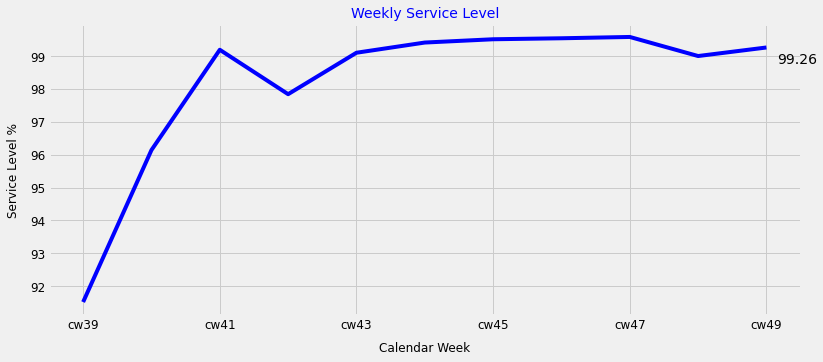

In [128]:
x='Movement_Week'
y='Service_Level_%'


style.use('fivethirtyeight') # Style by FiveThirtyEight
dfSLW.plot(x,y,
           kind='line',
           figsize=(12,5),
           color='b',
           legend=None)
#plt.legend(loc='lower left',fontsize=12)
plt.title('Weekly Service Level',fontsize=14,color='b')
plt.xlabel('Calendar Week',fontsize=12,labelpad=10)
plt.ylabel('Service Level %',fontsize=12,labelpad=10)
#plt.xticks(dfSLW.index,dfSLW['Movement_Week'])              # Adds lines and labels for each week.
plt.tick_params(axis='both', which='major', labelsize=12)   # Manages the size of tick labels.

service_level_x_limits = plt.xlim()
service_level_x_datalabel = service_level_x_limits[1]-0.35
print(dfSLW['Service_Level_%'].iloc[7])

plt.annotate(dfSLW['Service_Level_%'].iloc[-1],
             xy=(service_level_x_datalabel,dfSLW['Service_Level_%'].iloc[-1]),
             xytext=(service_level_x_datalabel,(dfSLW['Service_Level_%'].iloc[-1]-0.5)))

plt.show()

Line graph for Daily Coverage. It has a data label for the latest day only. Graph shows the most accurate value on Mondays, because on these day we have data for the full previous week.

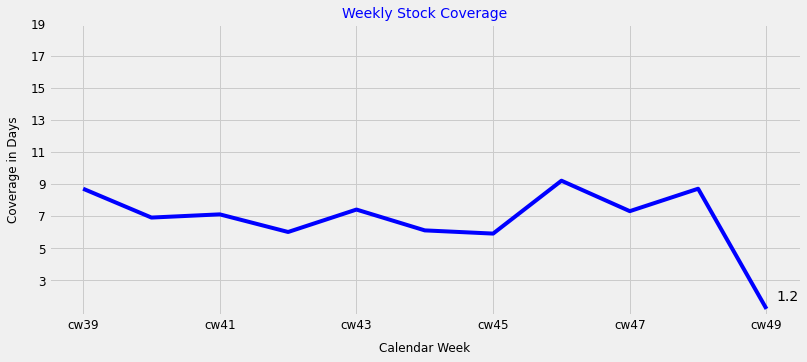

In [129]:
x='Movement_Week'
y='Total_Coverage'
# y2='Healthy_Coverage'


y_ticks = [3, 5, 7, 9, 11, 13, 15, 17, 19]


style.use('fivethirtyeight') # Style by Seaborn
dfTCW.plot(x,y,
            kind='line',
            figsize=(12,5),
            color=('b'),
            legend=None)
           
# label='Total Coverage')
plt.title('Weekly Stock Coverage',fontsize=14,color='b')
plt.xlabel('Calendar Week',fontsize=12,labelpad=10)
plt.ylabel('Coverage in Days',fontsize=12,labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.xticks(x_ticks)
plt.yticks(y_ticks)
# plt.legend(title=None,frameon=False)

coverage_x_limits = plt.xlim()
coverage_x_datalabel = coverage_x_limits[1]-0.35


plt.annotate(dfTCW['Total_Coverage'].iloc[-1],
             xy=(coverage_x_datalabel,dfTCW['Total_Coverage'].iloc[-1]),
             xytext=(coverage_x_datalabel,(dfTCW['Total_Coverage'].iloc[-1]+0.5)))


plt.show()

We prepare the dataframe with KPI overview for the last 7 days. Later it will be edited and sent via e-mail.

In [130]:
dfKPI_email = dfKPI.head(7)
dfKPI_email = dfKPI_email.rename(columns={'Movement_Date':'Movement Date','Total_Coverage':'Stock Coverage (days)', \
                                          'Service_Level':'Service Level'})
dfKPI_email['Movement Date'] = dfKPI_email['Movement Date'].dt.strftime('%d.%m.%Y')

dfKPI_email = dfKPI_email.rename_axis(None,axis=1)

HTML-table is prepared and sent via e-mail.

In [131]:
outlook = win32.Dispatch('outlook.application')
mail = outlook.CreateItem(0)
mail.To = 'user@domain.com'
mail.Subject = 'KPI Daily'

html2 = (
    dfKPI_email.style
    .format({'Stock Coverage (days)': "{:,.1f}"})
    .set_properties(subset=['Stock Coverage (days)'], **{'width': '170px'})
    .set_table_styles([{'selector' : '','props' : [('border', '1px solid blue'),('font-size', '13pt')]}])
    .set_properties(**{'font-size': '12pt', 'font-family': 'Arial','text-align': 'center'})
    .set_caption('Overview of DC performance for '+(datetime.now()-timedelta(days=1)).strftime("%B %d, %Y"))
    .hide_index()
    .render()
)

mail.HTMLBody = html2
mail.Send()